# Breaking a CAPTCHA system

Ref: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

In [1]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

Install some packages below (if not installed already):

In [2]:
!pip install opencv-python --user
!pip install imutils --user

In this exercise you will break `Really Simple CAPTCHA` plugin of WordPress: https://wordpress.org/plugins/really-simple-captcha/

Try a demo here: https://contactform7.com/captcha/

The plugin generates 4-letter CAPTCHAs using a random mix of four different fonts. Letters are from 'ABCDEFGHJKLMNPQRSTUVWXYZ23456789' and "O", "I" and "1" are not used to avoid user confusion. That leaves us with a total of 32 possible letters and numbers that we need to recognize.

Since we have the source code to the WordPress plug-in, we can modify it to save out CAPTCHA images along with the expected answer for each image. We generated 9955 images under folder `generated_captcha_images`. Run the following code to show 10 images to take a look.

In [3]:
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"

## Step 1: Extract single letters from CAPTCHA images

### Run the following code to show 10 images to take a look.

In [4]:
import os.path
import glob # glob.glob returns the list of files with their full path, and it supports wildcards

from IPython.display import Image

captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))

for (i, captcha_image_file) in enumerate(captcha_image_files):
    if i==10: break
    print(captcha_image_file)
    display(Image(filename=captcha_image_file))

generated_captcha_images/222X.png


generated_captcha_images/226U.png


generated_captcha_images/2274.png


generated_captcha_images/22A6.png


generated_captcha_images/22BJ.png


generated_captcha_images/22HS.png


generated_captcha_images/22KD.png


generated_captcha_images/22L9.png


generated_captcha_images/22NR.png


generated_captcha_images/22PL.png


### Now we illustrate how to process an image `generated_captcha_images/222X.png`

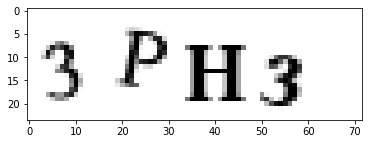

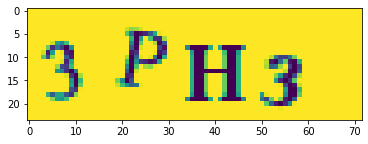

In [5]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt
import cv2 # OpenCV, a popular framework for computer vision and image processing

#captcha_image_file = 'generated_captcha_images/222X.png' # normal
#captcha_image_file = 'generated_captcha_images/2W4M.png' # try this: 3 objects, 2 letters are merged
captcha_image_file = 'generated_captcha_images/3PH3.png' # try this: 5 objects detected
# captcha_image_file = 'generated_captcha_images/JYU4.png' # try this: 6 objects detected

captcha_correct_text = os.path.splitext(captcha_image_file)[0]

# Load the image and convert it to grayscale
image = cv2.imread(captcha_image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Show the image with matplotlib
plt.imshow(image)
plt.show()

plt.imshow(gray)
plt.show()

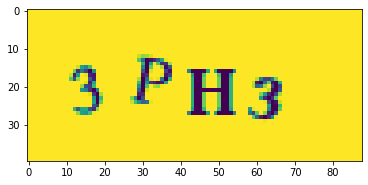

In [6]:
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

plt.imshow(gray)
plt.show()

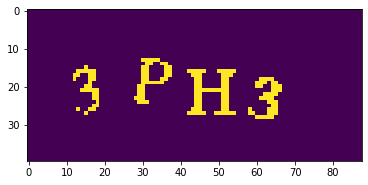

In [7]:
# threshold the image (convert it to pure black and white)
# we use Otsu’s binarization
# check: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(thresh)
plt.show()

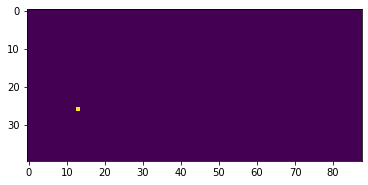

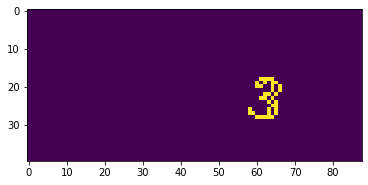

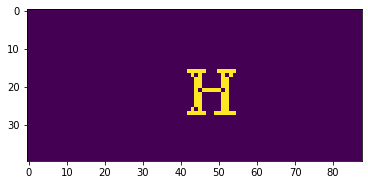

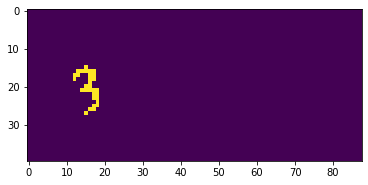

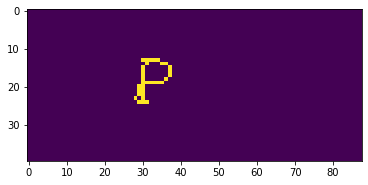

In [8]:
import numpy as np

# find the contours (continuous blobs of pixels) the image
# check:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

zero_img = np.zeros_like(thresh)

for i in range(len(contours)):
    temp = cv2.drawContours(zero_img.copy(), contours, i, (255,0,0), 1)
    plt.imshow(temp)
    plt.show()

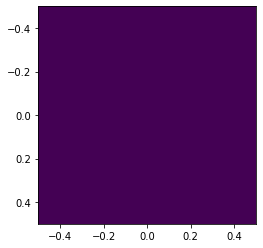

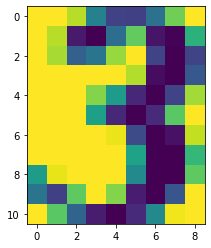

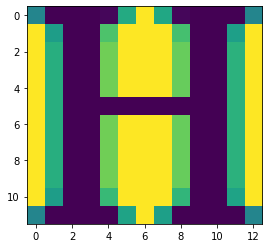

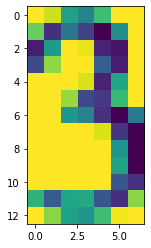

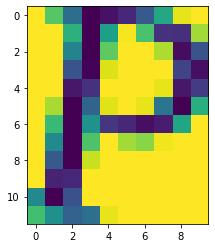

In [9]:
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image = gray[y:y+h, x:x+w]
    plt.imshow(letter_image)
    plt.show()

### Putting things together: get letters from images

Using what we have learnt above, write your code to save get the letters of all images. The letter-images are stored as 32 folders under folder `extracted_letter_images`.

For example, `extracted_letter_images/A` is a folder that saves all images of letter `A`. After you complete, each letter-folder should contain over 1000 letter-images.

Hint: (1) consider how to name different files in a letter-folder differently? (2) ingore those images with number of contours other than 4.

In [10]:
import os

LETTER_IMAGES_FOLDER = "extracted_letter_images" # the output for training
SKIPPED_FOLDER = "skipped_images" # those images are skipped
counts = {} # counts['A'] = number of 'A'-images, so that next 'A'-image can be named as counts['A'] + 1

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    #if i==10:
    #    break
    #############################################################################
    # TODO: your code here ...                                                  #
    #############################################################################
    captcha_correct_text = os.path.splitext(captcha_image_file)[0]
    #print(captcha_correct_text)
    captcha_text = captcha_correct_text.rsplit('/',1)[-1]
    print(captcha_text)
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    contours = sorted_contours
    zero_img = np.zeros_like(thresh)
    
    if len(contours) != 4:
        if not os.path.exists(SKIPPED_FOLDER):
            os.makedirs(SKIPPED_FOLDER)
        skip_path = os.path.join(SKIPPED_FOLDER, "{}.png".format(str(captcha_text)))
        cv2.imwrite(skip_path, thresh)
        continue
    
    counter = 0
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        letter_image = gray[y:y+h, x:x+w]
        #print(captcha_text[counter])
        save_path = os.path.join(LETTER_IMAGES_FOLDER, str(captcha_text[counter]))
        #print(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        if captcha_text[counter] not in counts:
            counts[captcha_text[counter]] = 1
            
        count = counts[captcha_text[counter]]
            
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        #print(p)
        cv2.imwrite(p, letter_image)
        
        counts[captcha_text[counter]] = count + 1
        counter = counter+1
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

[INFO] processing image 1/9955
222X
[INFO] processing image 2/9955
226U
[INFO] processing image 3/9955
2274
[INFO] processing image 4/9955
22A6
[INFO] processing image 5/9955
22BJ
[INFO] processing image 6/9955
22HS
[INFO] processing image 7/9955
22KD
[INFO] processing image 8/9955
22L9
[INFO] processing image 9/9955
22NR
[INFO] processing image 10/9955
22PL
[INFO] processing image 11/9955
22SS
[INFO] processing image 12/9955
22UX
[INFO] processing image 13/9955
23D7
[INFO] processing image 14/9955
23EZ
[INFO] processing image 15/9955
23FQ
[INFO] processing image 16/9955
23T2
[INFO] processing image 17/9955
23XT
[INFO] processing image 18/9955
243B
[INFO] processing image 19/9955
248C
[INFO] processing image 20/9955
24FJ
[INFO] processing image 21/9955
24FK
[INFO] processing image 22/9955
24HA
[INFO] processing image 23/9955
24HK
[INFO] processing image 24/9955
24XX
[INFO] processing image 25/9955
24Z5
[INFO] processing image 26/9955
24ZK
[INFO] processing image 27/9955
2544
[INFO] pro

[INFO] processing image 224/9955
2QRH
[INFO] processing image 225/9955
2QS7
[INFO] processing image 226/9955
2QSE
[INFO] processing image 227/9955
2QSL
[INFO] processing image 228/9955
2QTQ
[INFO] processing image 229/9955
2QVU
[INFO] processing image 230/9955
2QX5
[INFO] processing image 231/9955
2QZE
[INFO] processing image 232/9955
2R4L
[INFO] processing image 233/9955
2R9W
[INFO] processing image 234/9955
2RAU
[INFO] processing image 235/9955
2RM2
[INFO] processing image 236/9955
2RQ6
[INFO] processing image 237/9955
2RTS
[INFO] processing image 238/9955
2SBQ
[INFO] processing image 239/9955
2SCC
[INFO] processing image 240/9955
2SD4
[INFO] processing image 241/9955
2SEN
[INFO] processing image 242/9955
2SKC
[INFO] processing image 243/9955
2SM9
[INFO] processing image 244/9955
2SPF
[INFO] processing image 245/9955
2SQW
[INFO] processing image 246/9955
2SRU
[INFO] processing image 247/9955
2SSG
[INFO] processing image 248/9955
2SSU
[INFO] processing image 249/9955
2T3G
[INFO] proce

[INFO] processing image 445/9955
3EZK
[INFO] processing image 446/9955
3F2L
[INFO] processing image 447/9955
3F4E
[INFO] processing image 448/9955
3F6P
[INFO] processing image 449/9955
3F7P
[INFO] processing image 450/9955
3F9N
[INFO] processing image 451/9955
3FFN
[INFO] processing image 452/9955
3FNF
[INFO] processing image 453/9955
3FTA
[INFO] processing image 454/9955
3FXJ
[INFO] processing image 455/9955
3FXP
[INFO] processing image 456/9955
3FZG
[INFO] processing image 457/9955
3FZN
[INFO] processing image 458/9955
3G34
[INFO] processing image 459/9955
3G6V
[INFO] processing image 460/9955
3G86
[INFO] processing image 461/9955
3G9T
[INFO] processing image 462/9955
3GYK
[INFO] processing image 463/9955
3H3F
[INFO] processing image 464/9955
3H65
[INFO] processing image 465/9955
3H9X
[INFO] processing image 466/9955
3HBA
[INFO] processing image 467/9955
3HHL
[INFO] processing image 468/9955
3HKM
[INFO] processing image 469/9955
3HMA
[INFO] processing image 470/9955
3HSK
[INFO] proce

[INFO] processing image 668/9955
45R8
[INFO] processing image 669/9955
45T5
[INFO] processing image 670/9955
45ZX
[INFO] processing image 671/9955
463Z
[INFO] processing image 672/9955
465E
[INFO] processing image 673/9955
466E
[INFO] processing image 674/9955
466F
[INFO] processing image 675/9955
4688
[INFO] processing image 676/9955
46B4
[INFO] processing image 677/9955
46F6
[INFO] processing image 678/9955
46JM
[INFO] processing image 679/9955
46RD
[INFO] processing image 680/9955
46UZ
[INFO] processing image 681/9955
46VL
[INFO] processing image 682/9955
46XB
[INFO] processing image 683/9955
475V
[INFO] processing image 684/9955
47CN
[INFO] processing image 685/9955
47FG
[INFO] processing image 686/9955
47K4
[INFO] processing image 687/9955
47LH
[INFO] processing image 688/9955
47PR
[INFO] processing image 689/9955
47QJ
[INFO] processing image 690/9955
47UR
[INFO] processing image 691/9955
47UZ
[INFO] processing image 692/9955
47W4
[INFO] processing image 693/9955
47WK
[INFO] proce

[INFO] processing image 886/9955
4XGB
[INFO] processing image 887/9955
4XGC
[INFO] processing image 888/9955
4XGR
[INFO] processing image 889/9955
4XJ8
[INFO] processing image 890/9955
4XMK
[INFO] processing image 891/9955
4XMV
[INFO] processing image 892/9955
4XP5
[INFO] processing image 893/9955
4XPL
[INFO] processing image 894/9955
4XS9
[INFO] processing image 895/9955
4XXY
[INFO] processing image 896/9955
4XYU
[INFO] processing image 897/9955
4Y3H
[INFO] processing image 898/9955
4Y4E
[INFO] processing image 899/9955
4YF4
[INFO] processing image 900/9955
4YVG
[INFO] processing image 901/9955
4YZ3
[INFO] processing image 902/9955
4Z4H
[INFO] processing image 903/9955
4ZCM
[INFO] processing image 904/9955
4ZHD
[INFO] processing image 905/9955
4ZK5
[INFO] processing image 906/9955
4ZV8
[INFO] processing image 907/9955
4ZYV
[INFO] processing image 908/9955
522G
[INFO] processing image 909/9955
5233
[INFO] processing image 910/9955
5293
[INFO] processing image 911/9955
529S
[INFO] proce

[INFO] processing image 1100/9955
5ND2
[INFO] processing image 1101/9955
5NJ8
[INFO] processing image 1102/9955
5NKL
[INFO] processing image 1103/9955
5NNU
[INFO] processing image 1104/9955
5NS9
[INFO] processing image 1105/9955
5NUW
[INFO] processing image 1106/9955
5P3S
[INFO] processing image 1107/9955
5P46
[INFO] processing image 1108/9955
5PKG
[INFO] processing image 1109/9955
5PR8
[INFO] processing image 1110/9955
5PWA
[INFO] processing image 1111/9955
5Q3W
[INFO] processing image 1112/9955
5Q5E
[INFO] processing image 1113/9955
5Q73
[INFO] processing image 1114/9955
5Q9G
[INFO] processing image 1115/9955
5QAA
[INFO] processing image 1116/9955
5QEC
[INFO] processing image 1117/9955
5QHA
[INFO] processing image 1118/9955
5QKM
[INFO] processing image 1119/9955
5QMJ
[INFO] processing image 1120/9955
5QND
[INFO] processing image 1121/9955
5QPX
[INFO] processing image 1122/9955
5R25
[INFO] processing image 1123/9955
5R37
[INFO] processing image 1124/9955
5R4L
[INFO] processing image 1

[INFO] processing image 1321/9955
6G95
[INFO] processing image 1322/9955
6GHT
[INFO] processing image 1323/9955
6GLG
[INFO] processing image 1324/9955
6GQ6
[INFO] processing image 1325/9955
6GRN
[INFO] processing image 1326/9955
6GUH
[INFO] processing image 1327/9955
6GUQ
[INFO] processing image 1328/9955
6GZH
[INFO] processing image 1329/9955
6H4Z
[INFO] processing image 1330/9955
6H57
[INFO] processing image 1331/9955
6H8M
[INFO] processing image 1332/9955
6HDE
[INFO] processing image 1333/9955
6HNE
[INFO] processing image 1334/9955
6HPS
[INFO] processing image 1335/9955
6HR8
[INFO] processing image 1336/9955
6HS4
[INFO] processing image 1337/9955
6HUH
[INFO] processing image 1338/9955
6JC7
[INFO] processing image 1339/9955
6JCZ
[INFO] processing image 1340/9955
6JDP
[INFO] processing image 1341/9955
6JHB
[INFO] processing image 1342/9955
6JJ4
[INFO] processing image 1343/9955
6JPN
[INFO] processing image 1344/9955
6JRF
[INFO] processing image 1345/9955
6JST
[INFO] processing image 1

[INFO] processing image 1534/9955
78BV
[INFO] processing image 1535/9955
78JY
[INFO] processing image 1536/9955
78SV
[INFO] processing image 1537/9955
78VU
[INFO] processing image 1538/9955
79CH
[INFO] processing image 1539/9955
79HP
[INFO] processing image 1540/9955
79KZ
[INFO] processing image 1541/9955
79YS
[INFO] processing image 1542/9955
79ZE
[INFO] processing image 1543/9955
7A25
[INFO] processing image 1544/9955
7A7T
[INFO] processing image 1545/9955
7A8B
[INFO] processing image 1546/9955
7AE8
[INFO] processing image 1547/9955
7AET
[INFO] processing image 1548/9955
7ANC
[INFO] processing image 1549/9955
7AYB
[INFO] processing image 1550/9955
7B46
[INFO] processing image 1551/9955
7B53
[INFO] processing image 1552/9955
7B74
[INFO] processing image 1553/9955
7BD7
[INFO] processing image 1554/9955
7BLG
[INFO] processing image 1555/9955
7BM6
[INFO] processing image 1556/9955
7BPB
[INFO] processing image 1557/9955
7BYT
[INFO] processing image 1558/9955
7BZA
[INFO] processing image 1

[INFO] processing image 1752/9955
7Y4S
[INFO] processing image 1753/9955
7Y69
[INFO] processing image 1754/9955
7Y7J
[INFO] processing image 1755/9955
7Y9L
[INFO] processing image 1756/9955
7YCM
[INFO] processing image 1757/9955
7YD3
[INFO] processing image 1758/9955
7YH3
[INFO] processing image 1759/9955
7YHQ
[INFO] processing image 1760/9955
7YK4
[INFO] processing image 1761/9955
7YP7
[INFO] processing image 1762/9955
7YWS
[INFO] processing image 1763/9955
7YY3
[INFO] processing image 1764/9955
7ZBK
[INFO] processing image 1765/9955
7ZBW
[INFO] processing image 1766/9955
7ZE5
[INFO] processing image 1767/9955
7ZEB
[INFO] processing image 1768/9955
7ZHA
[INFO] processing image 1769/9955
7ZLB
[INFO] processing image 1770/9955
7ZNQ
[INFO] processing image 1771/9955
7ZQR
[INFO] processing image 1772/9955
7ZQU
[INFO] processing image 1773/9955
827H
[INFO] processing image 1774/9955
828V
[INFO] processing image 1775/9955
82A2
[INFO] processing image 1776/9955
82DE
[INFO] processing image 1

[INFO] processing image 1963/9955
8MRD
[INFO] processing image 1964/9955
8MWE
[INFO] processing image 1965/9955
8MX6
[INFO] processing image 1966/9955
8N6Z
[INFO] processing image 1967/9955
8N8A
[INFO] processing image 1968/9955
8NGX
[INFO] processing image 1969/9955
8NH2
[INFO] processing image 1970/9955
8NHE
[INFO] processing image 1971/9955
8NMF
[INFO] processing image 1972/9955
8NRK
[INFO] processing image 1973/9955
8NSF
[INFO] processing image 1974/9955
8NT2
[INFO] processing image 1975/9955
8NXR
[INFO] processing image 1976/9955
8P33
[INFO] processing image 1977/9955
8P48
[INFO] processing image 1978/9955
8PKY
[INFO] processing image 1979/9955
8PMF
[INFO] processing image 1980/9955
8PMS
[INFO] processing image 1981/9955
8PNJ
[INFO] processing image 1982/9955
8PRP
[INFO] processing image 1983/9955
8PV8
[INFO] processing image 1984/9955
8PY7
[INFO] processing image 1985/9955
8QBW
[INFO] processing image 1986/9955
8QC9
[INFO] processing image 1987/9955
8QEG
[INFO] processing image 1

[INFO] processing image 2182/9955
9AD7
[INFO] processing image 2183/9955
9AHB
[INFO] processing image 2184/9955
9AHZ
[INFO] processing image 2185/9955
9AJ9
[INFO] processing image 2186/9955
9AKE
[INFO] processing image 2187/9955
9AKQ
[INFO] processing image 2188/9955
9AMH
[INFO] processing image 2189/9955
9AP6
[INFO] processing image 2190/9955
9APK
[INFO] processing image 2191/9955
9AQB
[INFO] processing image 2192/9955
9ATZ
[INFO] processing image 2193/9955
9B2X
[INFO] processing image 2194/9955
9B4Y
[INFO] processing image 2195/9955
9B8X
[INFO] processing image 2196/9955
9B9V
[INFO] processing image 2197/9955
9BBJ
[INFO] processing image 2198/9955
9BCC
[INFO] processing image 2199/9955
9BFW
[INFO] processing image 2200/9955
9BGK
[INFO] processing image 2201/9955
9BNP
[INFO] processing image 2202/9955
9BRX
[INFO] processing image 2203/9955
9BVF
[INFO] processing image 2204/9955
9BWW
[INFO] processing image 2205/9955
9BXB
[INFO] processing image 2206/9955
9BXX
[INFO] processing image 2

[INFO] processing image 2396/9955
9W4G
[INFO] processing image 2397/9955
9W78
[INFO] processing image 2398/9955
9WFS
[INFO] processing image 2399/9955
9WKR
[INFO] processing image 2400/9955
9WMD
[INFO] processing image 2401/9955
9WQA
[INFO] processing image 2402/9955
9WX3
[INFO] processing image 2403/9955
9WXQ
[INFO] processing image 2404/9955
9WZ6
[INFO] processing image 2405/9955
9WZK
[INFO] processing image 2406/9955
9X6K
[INFO] processing image 2407/9955
9X6L
[INFO] processing image 2408/9955
9X94
[INFO] processing image 2409/9955
9XBY
[INFO] processing image 2410/9955
9XFM
[INFO] processing image 2411/9955
9XH3
[INFO] processing image 2412/9955
9XMD
[INFO] processing image 2413/9955
9XMY
[INFO] processing image 2414/9955
9XQ6
[INFO] processing image 2415/9955
9XQV
[INFO] processing image 2416/9955
9XRZ
[INFO] processing image 2417/9955
9XT9
[INFO] processing image 2418/9955
9XWD
[INFO] processing image 2419/9955
9XXA
[INFO] processing image 2420/9955
9XYZ
[INFO] processing image 2

[INFO] processing image 2607/9955
AK8R
[INFO] processing image 2608/9955
AKB8
[INFO] processing image 2609/9955
AKBF
[INFO] processing image 2610/9955
AKC9
[INFO] processing image 2611/9955
AKDU
[INFO] processing image 2612/9955
AKGH
[INFO] processing image 2613/9955
AKLT
[INFO] processing image 2614/9955
AKNC
[INFO] processing image 2615/9955
AKPJ
[INFO] processing image 2616/9955
AKUN
[INFO] processing image 2617/9955
AKVZ
[INFO] processing image 2618/9955
AKY7
[INFO] processing image 2619/9955
AL4Q
[INFO] processing image 2620/9955
ALDQ
[INFO] processing image 2621/9955
ALLC
[INFO] processing image 2622/9955
ALP4
[INFO] processing image 2623/9955
AM39
[INFO] processing image 2624/9955
AM6C
[INFO] processing image 2625/9955
AMJU
[INFO] processing image 2626/9955
AMK4
[INFO] processing image 2627/9955
AMLK
[INFO] processing image 2628/9955
AMQU
[INFO] processing image 2629/9955
AMYM
[INFO] processing image 2630/9955
AMYP
[INFO] processing image 2631/9955
AMZW
[INFO] processing image 2

[INFO] processing image 2820/9955
B7E5
[INFO] processing image 2821/9955
B7J9
[INFO] processing image 2822/9955
B7JP
[INFO] processing image 2823/9955
B7N3
[INFO] processing image 2824/9955
B7S4
[INFO] processing image 2825/9955
B7UX
[INFO] processing image 2826/9955
B88D
[INFO] processing image 2827/9955
B89Z
[INFO] processing image 2828/9955
B8MZ
[INFO] processing image 2829/9955
B8TE
[INFO] processing image 2830/9955
B8V4
[INFO] processing image 2831/9955
B97S
[INFO] processing image 2832/9955
B995
[INFO] processing image 2833/9955
B9BA
[INFO] processing image 2834/9955
B9CX
[INFO] processing image 2835/9955
B9D6
[INFO] processing image 2836/9955
B9GZ
[INFO] processing image 2837/9955
B9HX
[INFO] processing image 2838/9955
B9JJ
[INFO] processing image 2839/9955
B9S2
[INFO] processing image 2840/9955
B9V8
[INFO] processing image 2841/9955
B9XJ
[INFO] processing image 2842/9955
BA5E
[INFO] processing image 2843/9955
BA74
[INFO] processing image 2844/9955
BA9H
[INFO] processing image 2

[INFO] processing image 3033/9955
BTYE
[INFO] processing image 3034/9955
BU3C
[INFO] processing image 3035/9955
BU5X
[INFO] processing image 3036/9955
BU8D
[INFO] processing image 3037/9955
BUJ6
[INFO] processing image 3038/9955
BUJM
[INFO] processing image 3039/9955
BUMG
[INFO] processing image 3040/9955
BUPP
[INFO] processing image 3041/9955
BURS
[INFO] processing image 3042/9955
BUUF
[INFO] processing image 3043/9955
BUUT
[INFO] processing image 3044/9955
BUUW
[INFO] processing image 3045/9955
BUV7
[INFO] processing image 3046/9955
BUVH
[INFO] processing image 3047/9955
BUWY
[INFO] processing image 3048/9955
BUYN
[INFO] processing image 3049/9955
BV4P
[INFO] processing image 3050/9955
BVBR
[INFO] processing image 3051/9955
BVE8
[INFO] processing image 3052/9955
BVER
[INFO] processing image 3053/9955
BVMB
[INFO] processing image 3054/9955
BVP9
[INFO] processing image 3055/9955
BVUM
[INFO] processing image 3056/9955
BW3X
[INFO] processing image 3057/9955
BW9N
[INFO] processing image 3

[INFO] processing image 3249/9955
CJU2
[INFO] processing image 3250/9955
CJW9
[INFO] processing image 3251/9955
CJYZ
[INFO] processing image 3252/9955
CK23
[INFO] processing image 3253/9955
CK4V
[INFO] processing image 3254/9955
CK6H
[INFO] processing image 3255/9955
CKAY
[INFO] processing image 3256/9955
CKHN
[INFO] processing image 3257/9955
CKJU
[INFO] processing image 3258/9955
CKQ3
[INFO] processing image 3259/9955
CKV2
[INFO] processing image 3260/9955
CL7M
[INFO] processing image 3261/9955
CLB6
[INFO] processing image 3262/9955
CLEY
[INFO] processing image 3263/9955
CLG7
[INFO] processing image 3264/9955
CLGH
[INFO] processing image 3265/9955
CLN7
[INFO] processing image 3266/9955
CLS9
[INFO] processing image 3267/9955
CLTY
[INFO] processing image 3268/9955
CLWH
[INFO] processing image 3269/9955
CM49
[INFO] processing image 3270/9955
CM8W
[INFO] processing image 3271/9955
CMCU
[INFO] processing image 3272/9955
CMFU
[INFO] processing image 3273/9955
CMHK
[INFO] processing image 3

[INFO] processing image 3466/9955
D7TD
[INFO] processing image 3467/9955
D7ZC
[INFO] processing image 3468/9955
D82A
[INFO] processing image 3469/9955
D86P
[INFO] processing image 3470/9955
D86Q
[INFO] processing image 3471/9955
D87D
[INFO] processing image 3472/9955
D8CH
[INFO] processing image 3473/9955
D8JW
[INFO] processing image 3474/9955
D8Q4
[INFO] processing image 3475/9955
D8QT
[INFO] processing image 3476/9955
D8RK
[INFO] processing image 3477/9955
D8RN
[INFO] processing image 3478/9955
D8W4
[INFO] processing image 3479/9955
D92X
[INFO] processing image 3480/9955
D93S
[INFO] processing image 3481/9955
D93V
[INFO] processing image 3482/9955
D95Q
[INFO] processing image 3483/9955
D98Y
[INFO] processing image 3484/9955
D9AT
[INFO] processing image 3485/9955
D9HT
[INFO] processing image 3486/9955
D9KA
[INFO] processing image 3487/9955
D9M6
[INFO] processing image 3488/9955
D9PN
[INFO] processing image 3489/9955
D9RN
[INFO] processing image 3490/9955
D9RT
[INFO] processing image 3

[INFO] processing image 3678/9955
DSYF
[INFO] processing image 3679/9955
DT8J
[INFO] processing image 3680/9955
DTBG
[INFO] processing image 3681/9955
DTBW
[INFO] processing image 3682/9955
DTN8
[INFO] processing image 3683/9955
DTPH
[INFO] processing image 3684/9955
DTTU
[INFO] processing image 3685/9955
DTVE
[INFO] processing image 3686/9955
DTWA
[INFO] processing image 3687/9955
DU2X
[INFO] processing image 3688/9955
DUP6
[INFO] processing image 3689/9955
DUQV
[INFO] processing image 3690/9955
DUUX
[INFO] processing image 3691/9955
DUVF
[INFO] processing image 3692/9955
DUVZ
[INFO] processing image 3693/9955
DUZW
[INFO] processing image 3694/9955
DV2N
[INFO] processing image 3695/9955
DV76
[INFO] processing image 3696/9955
DV7T
[INFO] processing image 3697/9955
DVAJ
[INFO] processing image 3698/9955
DVCT
[INFO] processing image 3699/9955
DVJC
[INFO] processing image 3700/9955
DVJE
[INFO] processing image 3701/9955
DVLD
[INFO] processing image 3702/9955
DVMQ
[INFO] processing image 3

[INFO] processing image 3889/9955
EEA5
[INFO] processing image 3890/9955
EEBX
[INFO] processing image 3891/9955
EECS
[INFO] processing image 3892/9955
EEGB
[INFO] processing image 3893/9955
EEKS
[INFO] processing image 3894/9955
EER9
[INFO] processing image 3895/9955
EERF
[INFO] processing image 3896/9955
EEV4
[INFO] processing image 3897/9955
EEVE
[INFO] processing image 3898/9955
EF2E
[INFO] processing image 3899/9955
EF4D
[INFO] processing image 3900/9955
EF8A
[INFO] processing image 3901/9955
EF93
[INFO] processing image 3902/9955
EFM7
[INFO] processing image 3903/9955
EFNC
[INFO] processing image 3904/9955
EFTZ
[INFO] processing image 3905/9955
EFVZ
[INFO] processing image 3906/9955
EFXW
[INFO] processing image 3907/9955
EFYK
[INFO] processing image 3908/9955
EG3L
[INFO] processing image 3909/9955
EG49
[INFO] processing image 3910/9955
EG64
[INFO] processing image 3911/9955
EGB4
[INFO] processing image 3912/9955
EGBC
[INFO] processing image 3913/9955
EGBV
[INFO] processing image 3

[INFO] processing image 4100/9955
F2LH
[INFO] processing image 4101/9955
F2RE
[INFO] processing image 4102/9955
F2TZ
[INFO] processing image 4103/9955
F2XH
[INFO] processing image 4104/9955
F2Y7
[INFO] processing image 4105/9955
F35H
[INFO] processing image 4106/9955
F399
[INFO] processing image 4107/9955
F3C9
[INFO] processing image 4108/9955
F3FR
[INFO] processing image 4109/9955
F3PF
[INFO] processing image 4110/9955
F3SJ
[INFO] processing image 4111/9955
F3XJ
[INFO] processing image 4112/9955
F3Y3
[INFO] processing image 4113/9955
F3Y4
[INFO] processing image 4114/9955
F42C
[INFO] processing image 4115/9955
F4AH
[INFO] processing image 4116/9955
F4BQ
[INFO] processing image 4117/9955
F4DR
[INFO] processing image 4118/9955
F4H5
[INFO] processing image 4119/9955
F4HX
[INFO] processing image 4120/9955
F4MN
[INFO] processing image 4121/9955
F4MZ
[INFO] processing image 4122/9955
F4NL
[INFO] processing image 4123/9955
F4TG
[INFO] processing image 4124/9955
F4XK
[INFO] processing image 4

[INFO] processing image 4316/9955
FS3U
[INFO] processing image 4317/9955
FS8U
[INFO] processing image 4318/9955
FS9Y
[INFO] processing image 4319/9955
FSDB
[INFO] processing image 4320/9955
FSEB
[INFO] processing image 4321/9955
FSGG
[INFO] processing image 4322/9955
FSL5
[INFO] processing image 4323/9955
FSM5
[INFO] processing image 4324/9955
FSN4
[INFO] processing image 4325/9955
FSTB
[INFO] processing image 4326/9955
FSU7
[INFO] processing image 4327/9955
FSV4
[INFO] processing image 4328/9955
FSWA
[INFO] processing image 4329/9955
FT56
[INFO] processing image 4330/9955
FT5X
[INFO] processing image 4331/9955
FT6T
[INFO] processing image 4332/9955
FT9S
[INFO] processing image 4333/9955
FTBB
[INFO] processing image 4334/9955
FTEA
[INFO] processing image 4335/9955
FTHX
[INFO] processing image 4336/9955
FTNA
[INFO] processing image 4337/9955
FTQ9
[INFO] processing image 4338/9955
FTT4
[INFO] processing image 4339/9955
FTWB
[INFO] processing image 4340/9955
FU2D
[INFO] processing image 4

[INFO] processing image 4532/9955
GFAR
[INFO] processing image 4533/9955
GFFJ
[INFO] processing image 4534/9955
GFK7
[INFO] processing image 4535/9955
GFMY
[INFO] processing image 4536/9955
GFNC
[INFO] processing image 4537/9955
GFPC
[INFO] processing image 4538/9955
GFRT
[INFO] processing image 4539/9955
GFVD
[INFO] processing image 4540/9955
GFW4
[INFO] processing image 4541/9955
GFW5
[INFO] processing image 4542/9955
GFX5
[INFO] processing image 4543/9955
GFY2
[INFO] processing image 4544/9955
GG53
[INFO] processing image 4545/9955
GG78
[INFO] processing image 4546/9955
GG7Q
[INFO] processing image 4547/9955
GGEL
[INFO] processing image 4548/9955
GGNS
[INFO] processing image 4549/9955
GGPX
[INFO] processing image 4550/9955
GGSC
[INFO] processing image 4551/9955
GGVH
[INFO] processing image 4552/9955
GGX2
[INFO] processing image 4553/9955
GH3C
[INFO] processing image 4554/9955
GH5Z
[INFO] processing image 4555/9955
GH7V
[INFO] processing image 4556/9955
GHSZ
[INFO] processing image 4

[INFO] processing image 4743/9955
H5CR
[INFO] processing image 4744/9955
H5JA
[INFO] processing image 4745/9955
H5PT
[INFO] processing image 4746/9955
H5QN
[INFO] processing image 4747/9955
H5TL
[INFO] processing image 4748/9955
H5WP
[INFO] processing image 4749/9955
H5YB
[INFO] processing image 4750/9955
H5YV
[INFO] processing image 4751/9955
H6CA
[INFO] processing image 4752/9955
H6D7
[INFO] processing image 4753/9955
H6FT
[INFO] processing image 4754/9955
H6TK
[INFO] processing image 4755/9955
H6V7
[INFO] processing image 4756/9955
H72L
[INFO] processing image 4757/9955
H72Z
[INFO] processing image 4758/9955
H74P
[INFO] processing image 4759/9955
H77E
[INFO] processing image 4760/9955
H7A3
[INFO] processing image 4761/9955
H7TT
[INFO] processing image 4762/9955
H7YM
[INFO] processing image 4763/9955
H839
[INFO] processing image 4764/9955
H8EQ
[INFO] processing image 4765/9955
H8HT
[INFO] processing image 4766/9955
H8Q7
[INFO] processing image 4767/9955
H8ST
[INFO] processing image 4

[INFO] processing image 4967/9955
HWEU
[INFO] processing image 4968/9955
HWG5
[INFO] processing image 4969/9955
HWG9
[INFO] processing image 4970/9955
HWGW
[INFO] processing image 4971/9955
HWN8
[INFO] processing image 4972/9955
HWRY
[INFO] processing image 4973/9955
HWWQ
[INFO] processing image 4974/9955
HWZ4
[INFO] processing image 4975/9955
HX24
[INFO] processing image 4976/9955
HX5X
[INFO] processing image 4977/9955
HX9J
[INFO] processing image 4978/9955
HXJ4
[INFO] processing image 4979/9955
HXKF
[INFO] processing image 4980/9955
HXKW
[INFO] processing image 4981/9955
HXMC
[INFO] processing image 4982/9955
HXTY
[INFO] processing image 4983/9955
HY2R
[INFO] processing image 4984/9955
HY93
[INFO] processing image 4985/9955
HYD2
[INFO] processing image 4986/9955
HYUL
[INFO] processing image 4987/9955
HZ3E
[INFO] processing image 4988/9955
HZ3W
[INFO] processing image 4989/9955
HZD5
[INFO] processing image 4990/9955
HZLA
[INFO] processing image 4991/9955
HZS5
[INFO] processing image 4

[INFO] processing image 5185/9955
JLHT
[INFO] processing image 5186/9955
JLLK
[INFO] processing image 5187/9955
JLNY
[INFO] processing image 5188/9955
JLRU
[INFO] processing image 5189/9955
JLXM
[INFO] processing image 5190/9955
JM4B
[INFO] processing image 5191/9955
JM67
[INFO] processing image 5192/9955
JM7M
[INFO] processing image 5193/9955
JMA9
[INFO] processing image 5194/9955
JMFE
[INFO] processing image 5195/9955
JMFK
[INFO] processing image 5196/9955
JMGP
[INFO] processing image 5197/9955
JMH4
[INFO] processing image 5198/9955
JMN4
[INFO] processing image 5199/9955
JN6F
[INFO] processing image 5200/9955
JNGZ
[INFO] processing image 5201/9955
JNH3
[INFO] processing image 5202/9955
JNN9
[INFO] processing image 5203/9955
JNPV
[INFO] processing image 5204/9955
JNPY
[INFO] processing image 5205/9955
JNS9
[INFO] processing image 5206/9955
JNWA
[INFO] processing image 5207/9955
JP52
[INFO] processing image 5208/9955
JP7B
[INFO] processing image 5209/9955
JPHU
[INFO] processing image 5

[INFO] processing image 5398/9955
K9NW
[INFO] processing image 5399/9955
K9PY
[INFO] processing image 5400/9955
K9QH
[INFO] processing image 5401/9955
K9R8
[INFO] processing image 5402/9955
K9SJ
[INFO] processing image 5403/9955
K9UE
[INFO] processing image 5404/9955
K9WA
[INFO] processing image 5405/9955
K9XV
[INFO] processing image 5406/9955
K9ZT
[INFO] processing image 5407/9955
KA3U
[INFO] processing image 5408/9955
KA7G
[INFO] processing image 5409/9955
KA9W
[INFO] processing image 5410/9955
KAEQ
[INFO] processing image 5411/9955
KAJH
[INFO] processing image 5412/9955
KAJW
[INFO] processing image 5413/9955
KAQT
[INFO] processing image 5414/9955
KAUN
[INFO] processing image 5415/9955
KAUQ
[INFO] processing image 5416/9955
KAXL
[INFO] processing image 5417/9955
KBDC
[INFO] processing image 5418/9955
KBDL
[INFO] processing image 5419/9955
KBFS
[INFO] processing image 5420/9955
KBFT
[INFO] processing image 5421/9955
KBH6
[INFO] processing image 5422/9955
KBNG
[INFO] processing image 5

[INFO] processing image 5610/9955
KZFY
[INFO] processing image 5611/9955
KZG5
[INFO] processing image 5612/9955
KZHA
[INFO] processing image 5613/9955
KZHM
[INFO] processing image 5614/9955
KZKG
[INFO] processing image 5615/9955
KZKU
[INFO] processing image 5616/9955
KZNU
[INFO] processing image 5617/9955
KZPX
[INFO] processing image 5618/9955
KZQQ
[INFO] processing image 5619/9955
KZT3
[INFO] processing image 5620/9955
KZWJ
[INFO] processing image 5621/9955
KZZV
[INFO] processing image 5622/9955
L22Y
[INFO] processing image 5623/9955
L22Z
[INFO] processing image 5624/9955
L2BH
[INFO] processing image 5625/9955
L2ET
[INFO] processing image 5626/9955
L2GD
[INFO] processing image 5627/9955
L2KE
[INFO] processing image 5628/9955
L2L2
[INFO] processing image 5629/9955
L2LR
[INFO] processing image 5630/9955
L2NG
[INFO] processing image 5631/9955
L2ZJ
[INFO] processing image 5632/9955
L35N
[INFO] processing image 5633/9955
L37A
[INFO] processing image 5634/9955
L38F
[INFO] processing image 5

[INFO] processing image 5822/9955
LMHT
[INFO] processing image 5823/9955
LMHZ
[INFO] processing image 5824/9955
LMJD
[INFO] processing image 5825/9955
LMLH
[INFO] processing image 5826/9955
LMMW
[INFO] processing image 5827/9955
LMQH
[INFO] processing image 5828/9955
LMQW
[INFO] processing image 5829/9955
LMRW
[INFO] processing image 5830/9955
LMRX
[INFO] processing image 5831/9955
LMSA
[INFO] processing image 5832/9955
LMTN
[INFO] processing image 5833/9955
LNAW
[INFO] processing image 5834/9955
LNCM
[INFO] processing image 5835/9955
LNCU
[INFO] processing image 5836/9955
LNDC
[INFO] processing image 5837/9955
LNFJ
[INFO] processing image 5838/9955
LNKB
[INFO] processing image 5839/9955
LNMY
[INFO] processing image 5840/9955
LNQ7
[INFO] processing image 5841/9955
LP6Z
[INFO] processing image 5842/9955
LP94
[INFO] processing image 5843/9955
LPAD
[INFO] processing image 5844/9955
LPCD
[INFO] processing image 5845/9955
LPHV
[INFO] processing image 5846/9955
LPJQ
[INFO] processing image 5

[INFO] processing image 6039/9955
MBH9
[INFO] processing image 6040/9955
MBHV
[INFO] processing image 6041/9955
MBJD
[INFO] processing image 6042/9955
MBJY
[INFO] processing image 6043/9955
MBK2
[INFO] processing image 6044/9955
MBL5
[INFO] processing image 6045/9955
MBMH
[INFO] processing image 6046/9955
MBUU
[INFO] processing image 6047/9955
MBWL
[INFO] processing image 6048/9955
MBWX
[INFO] processing image 6049/9955
MC22
[INFO] processing image 6050/9955
MC29
[INFO] processing image 6051/9955
MC8H
[INFO] processing image 6052/9955
MCKA
[INFO] processing image 6053/9955
MCLR
[INFO] processing image 6054/9955
MCMM
[INFO] processing image 6055/9955
MCN8
[INFO] processing image 6056/9955
MCNM
[INFO] processing image 6057/9955
MCU9
[INFO] processing image 6058/9955
MCY7
[INFO] processing image 6059/9955
MD6N
[INFO] processing image 6060/9955
MD88
[INFO] processing image 6061/9955
MD8A
[INFO] processing image 6062/9955
MDAK
[INFO] processing image 6063/9955
MDD8
[INFO] processing image 6

[INFO] processing image 6259/9955
MZBS
[INFO] processing image 6260/9955
MZCP
[INFO] processing image 6261/9955
MZJR
[INFO] processing image 6262/9955
MZKW
[INFO] processing image 6263/9955
MZMR
[INFO] processing image 6264/9955
N225
[INFO] processing image 6265/9955
N2EU
[INFO] processing image 6266/9955
N2FD
[INFO] processing image 6267/9955
N2GR
[INFO] processing image 6268/9955
N2H7
[INFO] processing image 6269/9955
N2PL
[INFO] processing image 6270/9955
N2S2
[INFO] processing image 6271/9955
N2SR
[INFO] processing image 6272/9955
N2W3
[INFO] processing image 6273/9955
N356
[INFO] processing image 6274/9955
N363
[INFO] processing image 6275/9955
N36X
[INFO] processing image 6276/9955
N3FJ
[INFO] processing image 6277/9955
N3N6
[INFO] processing image 6278/9955
N3NY
[INFO] processing image 6279/9955
N3QR
[INFO] processing image 6280/9955
N3V7
[INFO] processing image 6281/9955
N46G
[INFO] processing image 6282/9955
N46X
[INFO] processing image 6283/9955
N49Y
[INFO] processing image 6

[INFO] processing image 6477/9955
NPYS
[INFO] processing image 6478/9955
NQ23
[INFO] processing image 6479/9955
NQ4U
[INFO] processing image 6480/9955
NQ6V
[INFO] processing image 6481/9955
NQ7T
[INFO] processing image 6482/9955
NQD4
[INFO] processing image 6483/9955
NQN2
[INFO] processing image 6484/9955
NQPS
[INFO] processing image 6485/9955
NQQ3
[INFO] processing image 6486/9955
NQR2
[INFO] processing image 6487/9955
NQSV
[INFO] processing image 6488/9955
NQZN
[INFO] processing image 6489/9955
NR56
[INFO] processing image 6490/9955
NR7H
[INFO] processing image 6491/9955
NRE7
[INFO] processing image 6492/9955
NRE9
[INFO] processing image 6493/9955
NRKY
[INFO] processing image 6494/9955
NRPX
[INFO] processing image 6495/9955
NRQT
[INFO] processing image 6496/9955
NRQW
[INFO] processing image 6497/9955
NRRB
[INFO] processing image 6498/9955
NS3V
[INFO] processing image 6499/9955
NS7X
[INFO] processing image 6500/9955
NS9N
[INFO] processing image 6501/9955
NSGH
[INFO] processing image 6

[INFO] processing image 6700/9955
PBFF
[INFO] processing image 6701/9955
PBJG
[INFO] processing image 6702/9955
PBJW
[INFO] processing image 6703/9955
PBL5
[INFO] processing image 6704/9955
PBLG
[INFO] processing image 6705/9955
PBRM
[INFO] processing image 6706/9955
PBWW
[INFO] processing image 6707/9955
PC64
[INFO] processing image 6708/9955
PCB6
[INFO] processing image 6709/9955
PCFT
[INFO] processing image 6710/9955
PCLS
[INFO] processing image 6711/9955
PCQL
[INFO] processing image 6712/9955
PCTX
[INFO] processing image 6713/9955
PCU7
[INFO] processing image 6714/9955
PCZH
[INFO] processing image 6715/9955
PD4D
[INFO] processing image 6716/9955
PD4Y
[INFO] processing image 6717/9955
PDBY
[INFO] processing image 6718/9955
PDC2
[INFO] processing image 6719/9955
PDFU
[INFO] processing image 6720/9955
PDMQ
[INFO] processing image 6721/9955
PDMT
[INFO] processing image 6722/9955
PDPK
[INFO] processing image 6723/9955
PDT9
[INFO] processing image 6724/9955
PDYD
[INFO] processing image 6

[INFO] processing image 6916/9955
PYZ2
[INFO] processing image 6917/9955
PZ4G
[INFO] processing image 6918/9955
PZ6V
[INFO] processing image 6919/9955
PZ7A
[INFO] processing image 6920/9955
PZE4
[INFO] processing image 6921/9955
PZMG
[INFO] processing image 6922/9955
PZRJ
[INFO] processing image 6923/9955
PZUH
[INFO] processing image 6924/9955
PZYS
[INFO] processing image 6925/9955
Q22A
[INFO] processing image 6926/9955
Q2AT
[INFO] processing image 6927/9955
Q2B7
[INFO] processing image 6928/9955
Q2BM
[INFO] processing image 6929/9955
Q2J6
[INFO] processing image 6930/9955
Q2MU
[INFO] processing image 6931/9955
Q2QH
[INFO] processing image 6932/9955
Q2UE
[INFO] processing image 6933/9955
Q2ZG
[INFO] processing image 6934/9955
Q33G
[INFO] processing image 6935/9955
Q35J
[INFO] processing image 6936/9955
Q36W
[INFO] processing image 6937/9955
Q3QW
[INFO] processing image 6938/9955
Q3XX
[INFO] processing image 6939/9955
Q3YH
[INFO] processing image 6940/9955
Q42K
[INFO] processing image 6

[INFO] processing image 7133/9955
QPSC
[INFO] processing image 7134/9955
QQ2F
[INFO] processing image 7135/9955
QQ38
[INFO] processing image 7136/9955
QQ47
[INFO] processing image 7137/9955
QQ4J
[INFO] processing image 7138/9955
QQ4N
[INFO] processing image 7139/9955
QQ7X
[INFO] processing image 7140/9955
QQ8X
[INFO] processing image 7141/9955
QQ9R
[INFO] processing image 7142/9955
QQCK
[INFO] processing image 7143/9955
QQFB
[INFO] processing image 7144/9955
QQHY
[INFO] processing image 7145/9955
QQJK
[INFO] processing image 7146/9955
QQQ9
[INFO] processing image 7147/9955
QQVU
[INFO] processing image 7148/9955
QR53
[INFO] processing image 7149/9955
QR7W
[INFO] processing image 7150/9955
QRJ8
[INFO] processing image 7151/9955
QRPX
[INFO] processing image 7152/9955
QRVH
[INFO] processing image 7153/9955
QS4S
[INFO] processing image 7154/9955
QSCD
[INFO] processing image 7155/9955
QSD7
[INFO] processing image 7156/9955
QSFW
[INFO] processing image 7157/9955
QSH7
[INFO] processing image 7

[INFO] processing image 7350/9955
RG6Y
[INFO] processing image 7351/9955
RG7C
[INFO] processing image 7352/9955
RG9A
[INFO] processing image 7353/9955
RGAY
[INFO] processing image 7354/9955
RGD3
[INFO] processing image 7355/9955
RGFS
[INFO] processing image 7356/9955
RGHJ
[INFO] processing image 7357/9955
RGHQ
[INFO] processing image 7358/9955
RGNM
[INFO] processing image 7359/9955
RGRX
[INFO] processing image 7360/9955
RGSM
[INFO] processing image 7361/9955
RH28
[INFO] processing image 7362/9955
RH3M
[INFO] processing image 7363/9955
RH3X
[INFO] processing image 7364/9955
RHDK
[INFO] processing image 7365/9955
RHK7
[INFO] processing image 7366/9955
RHNB
[INFO] processing image 7367/9955
RHQ8
[INFO] processing image 7368/9955
RHRW
[INFO] processing image 7369/9955
RHSV
[INFO] processing image 7370/9955
RHTG
[INFO] processing image 7371/9955
RHWV
[INFO] processing image 7372/9955
RJ27
[INFO] processing image 7373/9955
RJ69
[INFO] processing image 7374/9955
RJ82
[INFO] processing image 7

[INFO] processing image 7569/9955
S668
[INFO] processing image 7570/9955
S6KY
[INFO] processing image 7571/9955
S6R7
[INFO] processing image 7572/9955
S6UG
[INFO] processing image 7573/9955
S6W9
[INFO] processing image 7574/9955
S73K
[INFO] processing image 7575/9955
S75Y
[INFO] processing image 7576/9955
S779
[INFO] processing image 7577/9955
S79B
[INFO] processing image 7578/9955
S7C6
[INFO] processing image 7579/9955
S7FK
[INFO] processing image 7580/9955
S7G5
[INFO] processing image 7581/9955
S7H2
[INFO] processing image 7582/9955
S7HD
[INFO] processing image 7583/9955
S7KY
[INFO] processing image 7584/9955
S7PQ
[INFO] processing image 7585/9955
S7QF
[INFO] processing image 7586/9955
S7QV
[INFO] processing image 7587/9955
S7QW
[INFO] processing image 7588/9955
S7YP
[INFO] processing image 7589/9955
S7Z5
[INFO] processing image 7590/9955
S7ZJ
[INFO] processing image 7591/9955
S849
[INFO] processing image 7592/9955
S88M
[INFO] processing image 7593/9955
S88Q
[INFO] processing image 7

[INFO] processing image 7783/9955
SUKP
[INFO] processing image 7784/9955
SUNQ
[INFO] processing image 7785/9955
SUQU
[INFO] processing image 7786/9955
SUTR
[INFO] processing image 7787/9955
SUVX
[INFO] processing image 7788/9955
SUXA
[INFO] processing image 7789/9955
SV8X
[INFO] processing image 7790/9955
SV8Y
[INFO] processing image 7791/9955
SV95
[INFO] processing image 7792/9955
SVD9
[INFO] processing image 7793/9955
SVGM
[INFO] processing image 7794/9955
SVKV
[INFO] processing image 7795/9955
SVNQ
[INFO] processing image 7796/9955
SVPK
[INFO] processing image 7797/9955
SVR7
[INFO] processing image 7798/9955
SVUV
[INFO] processing image 7799/9955
SW4H
[INFO] processing image 7800/9955
SW7F
[INFO] processing image 7801/9955
SW93
[INFO] processing image 7802/9955
SWCQ
[INFO] processing image 7803/9955
SWKT
[INFO] processing image 7804/9955
SWKW
[INFO] processing image 7805/9955
SWMV
[INFO] processing image 7806/9955
SWNL
[INFO] processing image 7807/9955
SWSA
[INFO] processing image 7

[INFO] processing image 7999/9955
TL2L
[INFO] processing image 8000/9955
TL9R
[INFO] processing image 8001/9955
TLBS
[INFO] processing image 8002/9955
TLLJ
[INFO] processing image 8003/9955
TLPE
[INFO] processing image 8004/9955
TLSJ
[INFO] processing image 8005/9955
TLTZ
[INFO] processing image 8006/9955
TLXJ
[INFO] processing image 8007/9955
TLZ5
[INFO] processing image 8008/9955
TLZN
[INFO] processing image 8009/9955
TM2C
[INFO] processing image 8010/9955
TM4A
[INFO] processing image 8011/9955
TMAC
[INFO] processing image 8012/9955
TMCU
[INFO] processing image 8013/9955
TMG7
[INFO] processing image 8014/9955
TMHN
[INFO] processing image 8015/9955
TMNN
[INFO] processing image 8016/9955
TMR8
[INFO] processing image 8017/9955
TMSR
[INFO] processing image 8018/9955
TMTV
[INFO] processing image 8019/9955
TMYR
[INFO] processing image 8020/9955
TN7M
[INFO] processing image 8021/9955
TN9Y
[INFO] processing image 8022/9955
TNFK
[INFO] processing image 8023/9955
TNNA
[INFO] processing image 8

[INFO] processing image 8217/9955
UBDP
[INFO] processing image 8218/9955
UBGM
[INFO] processing image 8219/9955
UBP8
[INFO] processing image 8220/9955
UBRS
[INFO] processing image 8221/9955
UBSF
[INFO] processing image 8222/9955
UBU2
[INFO] processing image 8223/9955
UBWE
[INFO] processing image 8224/9955
UBYC
[INFO] processing image 8225/9955
UCHH
[INFO] processing image 8226/9955
UCLS
[INFO] processing image 8227/9955
UCPG
[INFO] processing image 8228/9955
UCSS
[INFO] processing image 8229/9955
UCUR
[INFO] processing image 8230/9955
UD7E
[INFO] processing image 8231/9955
UDCA
[INFO] processing image 8232/9955
UDEF
[INFO] processing image 8233/9955
UDFT
[INFO] processing image 8234/9955
UDJX
[INFO] processing image 8235/9955
UDKC
[INFO] processing image 8236/9955
UDNW
[INFO] processing image 8237/9955
UDRB
[INFO] processing image 8238/9955
UDW2
[INFO] processing image 8239/9955
UEA8
[INFO] processing image 8240/9955
UEFC
[INFO] processing image 8241/9955
UEG9
[INFO] processing image 8

[INFO] processing image 8432/9955
V23N
[INFO] processing image 8433/9955
V28W
[INFO] processing image 8434/9955
V29L
[INFO] processing image 8435/9955
V2CK
[INFO] processing image 8436/9955
V2MF
[INFO] processing image 8437/9955
V2MK
[INFO] processing image 8438/9955
V2NZ
[INFO] processing image 8439/9955
V2UD
[INFO] processing image 8440/9955
V2YK
[INFO] processing image 8441/9955
V33E
[INFO] processing image 8442/9955
V3KA
[INFO] processing image 8443/9955
V3Q3
[INFO] processing image 8444/9955
V3S6
[INFO] processing image 8445/9955
V3TZ
[INFO] processing image 8446/9955
V3UG
[INFO] processing image 8447/9955
V3VX
[INFO] processing image 8448/9955
V3XU
[INFO] processing image 8449/9955
V47H
[INFO] processing image 8450/9955
V48B
[INFO] processing image 8451/9955
V497
[INFO] processing image 8452/9955
V4AR
[INFO] processing image 8453/9955
V4DG
[INFO] processing image 8454/9955
V4DR
[INFO] processing image 8455/9955
V4H5
[INFO] processing image 8456/9955
V4S5
[INFO] processing image 8

[INFO] processing image 8651/9955
VS9X
[INFO] processing image 8652/9955
VSAE
[INFO] processing image 8653/9955
VSEE
[INFO] processing image 8654/9955
VSH5
[INFO] processing image 8655/9955
VSHY
[INFO] processing image 8656/9955
VT6V
[INFO] processing image 8657/9955
VTC2
[INFO] processing image 8658/9955
VTG3
[INFO] processing image 8659/9955
VTHU
[INFO] processing image 8660/9955
VTJ5
[INFO] processing image 8661/9955
VTS2
[INFO] processing image 8662/9955
VTS5
[INFO] processing image 8663/9955
VTZF
[INFO] processing image 8664/9955
VU6X
[INFO] processing image 8665/9955
VU9P
[INFO] processing image 8666/9955
VUBF
[INFO] processing image 8667/9955
VUFN
[INFO] processing image 8668/9955
VUHK
[INFO] processing image 8669/9955
VULJ
[INFO] processing image 8670/9955
VUR9
[INFO] processing image 8671/9955
VUTV
[INFO] processing image 8672/9955
VV3N
[INFO] processing image 8673/9955
VV4K
[INFO] processing image 8674/9955
VVDY
[INFO] processing image 8675/9955
VVNC
[INFO] processing image 8

[INFO] processing image 8874/9955
WJDC
[INFO] processing image 8875/9955
WJQP
[INFO] processing image 8876/9955
WJQT
[INFO] processing image 8877/9955
WJR3
[INFO] processing image 8878/9955
WJTN
[INFO] processing image 8879/9955
WJVB
[INFO] processing image 8880/9955
WJZY
[INFO] processing image 8881/9955
WK28
[INFO] processing image 8882/9955
WK9T
[INFO] processing image 8883/9955
WKAD
[INFO] processing image 8884/9955
WKBR
[INFO] processing image 8885/9955
WKLW
[INFO] processing image 8886/9955
WKMW
[INFO] processing image 8887/9955
WKN5
[INFO] processing image 8888/9955
WKTH
[INFO] processing image 8889/9955
WKVX
[INFO] processing image 8890/9955
WKW6
[INFO] processing image 8891/9955
WKXA
[INFO] processing image 8892/9955
WKYM
[INFO] processing image 8893/9955
WKZT
[INFO] processing image 8894/9955
WL3U
[INFO] processing image 8895/9955
WL9P
[INFO] processing image 8896/9955
WLCP
[INFO] processing image 8897/9955
WLEN
[INFO] processing image 8898/9955
WLFL
[INFO] processing image 8

[INFO] processing image 9090/9955
X8C8
[INFO] processing image 9091/9955
X8PM
[INFO] processing image 9092/9955
X8QD
[INFO] processing image 9093/9955
X8S3
[INFO] processing image 9094/9955
X8WB
[INFO] processing image 9095/9955
X95Q
[INFO] processing image 9096/9955
X963
[INFO] processing image 9097/9955
X96B
[INFO] processing image 9098/9955
X99X
[INFO] processing image 9099/9955
X9C4
[INFO] processing image 9100/9955
X9P6
[INFO] processing image 9101/9955
X9QF
[INFO] processing image 9102/9955
X9R7
[INFO] processing image 9103/9955
X9SV
[INFO] processing image 9104/9955
X9UT
[INFO] processing image 9105/9955
XA4L
[INFO] processing image 9106/9955
XACK
[INFO] processing image 9107/9955
XACQ
[INFO] processing image 9108/9955
XAMJ
[INFO] processing image 9109/9955
XANM
[INFO] processing image 9110/9955
XAX5
[INFO] processing image 9111/9955
XAZY
[INFO] processing image 9112/9955
XB44
[INFO] processing image 9113/9955
XB77
[INFO] processing image 9114/9955
XB78
[INFO] processing image 9

[INFO] processing image 9309/9955
XXJF
[INFO] processing image 9310/9955
XXKV
[INFO] processing image 9311/9955
XXMF
[INFO] processing image 9312/9955
XXUQ
[INFO] processing image 9313/9955
XXZB
[INFO] processing image 9314/9955
XXZZ
[INFO] processing image 9315/9955
XY4S
[INFO] processing image 9316/9955
XY4Z
[INFO] processing image 9317/9955
XY6M
[INFO] processing image 9318/9955
XY7N
[INFO] processing image 9319/9955
XY89
[INFO] processing image 9320/9955
XY9Q
[INFO] processing image 9321/9955
XYMB
[INFO] processing image 9322/9955
XYVX
[INFO] processing image 9323/9955
XZ4E
[INFO] processing image 9324/9955
XZ7M
[INFO] processing image 9325/9955
XZ88
[INFO] processing image 9326/9955
XZFJ
[INFO] processing image 9327/9955
XZGU
[INFO] processing image 9328/9955
XZHE
[INFO] processing image 9329/9955
XZKZ
[INFO] processing image 9330/9955
XZNL
[INFO] processing image 9331/9955
XZPE
[INFO] processing image 9332/9955
XZQT
[INFO] processing image 9333/9955
XZS9
[INFO] processing image 9

[INFO] processing image 9523/9955
YLGL
[INFO] processing image 9524/9955
YLK6
[INFO] processing image 9525/9955
YLKK
[INFO] processing image 9526/9955
YLV4
[INFO] processing image 9527/9955
YM2T
[INFO] processing image 9528/9955
YM57
[INFO] processing image 9529/9955
YM8X
[INFO] processing image 9530/9955
YM96
[INFO] processing image 9531/9955
YMBA
[INFO] processing image 9532/9955
YMEV
[INFO] processing image 9533/9955
YMFR
[INFO] processing image 9534/9955
YMKG
[INFO] processing image 9535/9955
YMRZ
[INFO] processing image 9536/9955
YN9N
[INFO] processing image 9537/9955
YNC8
[INFO] processing image 9538/9955
YNDG
[INFO] processing image 9539/9955
YNJA
[INFO] processing image 9540/9955
YNP7
[INFO] processing image 9541/9955
YNPM
[INFO] processing image 9542/9955
YNQV
[INFO] processing image 9543/9955
YNQW
[INFO] processing image 9544/9955
YNS3
[INFO] processing image 9545/9955
YP26
[INFO] processing image 9546/9955
YP3F
[INFO] processing image 9547/9955
YPB4
[INFO] processing image 9

[INFO] processing image 9737/9955
Z8TY
[INFO] processing image 9738/9955
Z8WM
[INFO] processing image 9739/9955
Z97U
[INFO] processing image 9740/9955
Z987
[INFO] processing image 9741/9955
Z996
[INFO] processing image 9742/9955
Z99E
[INFO] processing image 9743/9955
Z99X
[INFO] processing image 9744/9955
Z9AE
[INFO] processing image 9745/9955
Z9C7
[INFO] processing image 9746/9955
Z9GP
[INFO] processing image 9747/9955
Z9L8
[INFO] processing image 9748/9955
Z9M7
[INFO] processing image 9749/9955
Z9SS
[INFO] processing image 9750/9955
Z9V6
[INFO] processing image 9751/9955
Z9V7
[INFO] processing image 9752/9955
ZA32
[INFO] processing image 9753/9955
ZAB9
[INFO] processing image 9754/9955
ZABU
[INFO] processing image 9755/9955
ZAQZ
[INFO] processing image 9756/9955
ZB7G
[INFO] processing image 9757/9955
ZB9S
[INFO] processing image 9758/9955
ZBGP
[INFO] processing image 9759/9955
ZBL9
[INFO] processing image 9760/9955
ZBND
[INFO] processing image 9761/9955
ZBPB
[INFO] processing image 9

[INFO] processing image 9951/9955
ZZ3U
[INFO] processing image 9952/9955
ZZ7N
[INFO] processing image 9953/9955
ZZBA
[INFO] processing image 9954/9955
ZZBM
[INFO] processing image 9955/9955
ZZJJ


Now, folder `extracted_letter_images` should contain 32 folders, each storing the corresponding letter images

## Step 2: Train the neural network to recognize single letters

Since input layer of a neural network model takes images of fixed size (usually square), we need to resize images first.

(12, 7)


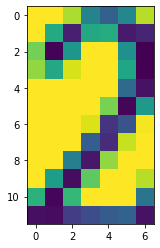

In [11]:
letter_image_file = 'extracted_letter_images/2/000001.png'

image = cv2.imread(letter_image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape) 
(h, w) = image.shape[:2] # note that cv.imread gets an array of h x w, h goes first
# add [:2] so that even if color image will work, not needed here though

plt.imshow(image)
plt.show()

Since `h > w`, we make sure `h` fits in our desired height value, e.g., 20:

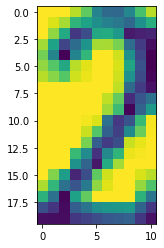

In [12]:
import imutils

image = imutils.resize(image, height=20)
# imutils.resize maintains the aspect ratio

plt.imshow(image)
plt.show()

Now we pad along width to make the image square, i.e., 20 x 20:

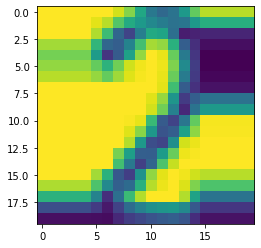

In [13]:
# determine the padding values for the width (= 20)
# to obtain the target dimensions
padW = int((20 - image.shape[1]) / 2.0) # may have rounding

# pad the image
image = cv2.copyMakeBorder(image, 0, 0, padW, padW,
        cv2.BORDER_REPLICATE)

# apply one more resizing to handle any rounding issues
image = cv2.resize(image, (20, 20))

plt.imshow(image)
plt.show()

Using what you learned, now write a function to resize images. Note that you also need to handle the possible case `h < w`:

In [14]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    - param image: image to resize
    - param width: desired width in pixels
    - param height: desired height in pixels
    - return: the resized image
    """

    #############################################################################
    # TODO: your code here ...                                                  #
    #############################################################################
    (h, w) = image.shape[:2]
    if w > h:
        image = imutils.resize(image, width=width)
    else:
        image = imutils.resize(image, height=height)

    padWidth = int((width - image.shape[1]) / 2.0)
    padHeight = int((height - image.shape[0]) / 2.0)
    image = cv2.copyMakeBorder(image, padHeight, padHeight, padWidth, padWidth, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # return the pre-processed image
    return image

Prepare the training and validating datasets:

In [33]:
from imutils import paths

# initialize the data and labels
data = []
labels = []

progress_folder = ''

# loop over the input images
# imutils.paths.list_images will list all images in the 32 subfolders
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    # extracted_letter_images/2/000001.png, after split
    # extracted_letter_images, 2, 000001.png
    # so 2 is the 2nd last, accessed using index -2
    
    if label != progress_folder:
        print('Processing Folder', label)
        progress_folder = label
    
    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

Processing Folder 2
Processing Folder X
Processing Folder 6
Processing Folder U
Processing Folder 7
Processing Folder 4
Processing Folder A
Processing Folder B
Processing Folder J
Processing Folder H
Processing Folder S
Processing Folder K
Processing Folder D
Processing Folder L
Processing Folder 9
Processing Folder N
Processing Folder R
Processing Folder P
Processing Folder 3
Processing Folder E
Processing Folder Z
Processing Folder F
Processing Folder Q
Processing Folder T
Processing Folder 8
Processing Folder C
Processing Folder 5
Processing Folder G
Processing Folder M
Processing Folder V
Processing Folder W
Processing Folder Y


Convert lists into NumPy arrays as required by Keras for input + data normalization:

In [16]:
# scale the raw pixel intensities to the range [0, 1] (this is important!!!)
data = np.array(data, dtype="float") / 255.0

# you may also use std rather than 255, and center the data by mean as follows:
#data = (np.array(data, dtype="float") - data.mean()) / data.std()
# in this case you need to remember the mean and std for use during testing later

# scaling is not needed if you use BatchNormalization after Conv2D and before Activation

labels = np.array(labels)

Split into training and validation datasets:

In [17]:
from sklearn.preprocessing import LabelBinarizer

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(labels)
print(lb.classes_)
labels = lb.transform(labels)
print()
print(labels)

['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [18]:
import pickle

MODEL_LABELS_FILENAME = "model_labels.dat"

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

Now we are ready to train it using Keras. We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

In [19]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 50)        9050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1250)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               625500    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1

In [21]:
!pip install pydot --user
!pip install graphviz --user

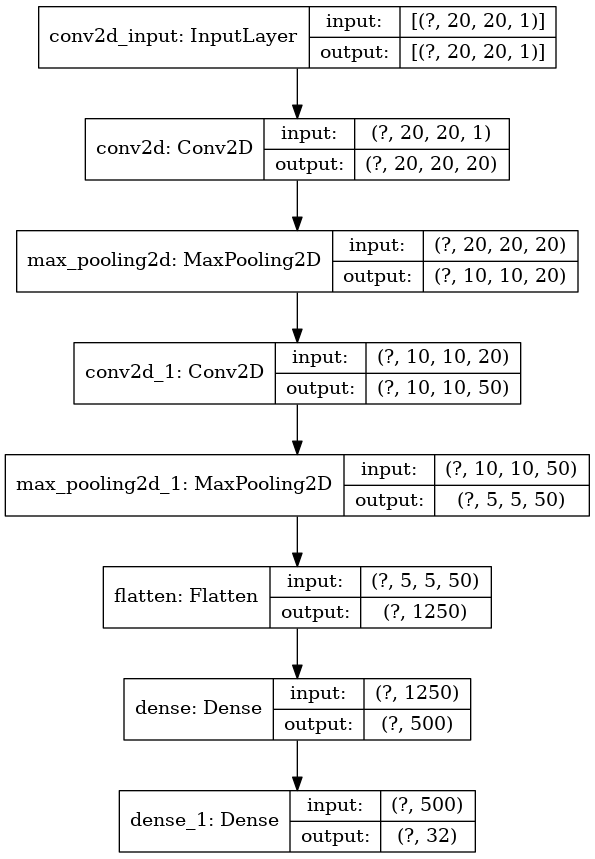

In [22]:
from tensorflow.keras.utils import plot_model

MODEL_PLOT_FILE = 'model_plot.png'
plot_model(model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True)
display(Image(filename=MODEL_PLOT_FILE))

Questions: (1) Why `conv2d_1` has 9050 parameters? (2) Why `dense` has 625500 parameters?

Hint: self-study http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf
    
**Type Your Answer Here:**

(1)
For conv2d_1, we can find the total number of parameters as follows:

parameters = channels_in * kernel_width * kernel_height * channels_out + number_of_channels = 20 * 3 * 3 * 50 + 50 = 9000 + 50 = 9050

(2) For dense we can calculate the parameters as follows:

parameters = (channels_input + 1) * channels_output = (1250+1)*500 = 625500


Now, let us do the actual training:

In [23]:
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

Train on 29097 samples, validate on 7275 samples
Epoch 1/10
29097/29097 [==============================] - 21s 731us/sample - loss: 0.1301 - accuracy: 0.9675 - val_loss: 25.2423 - val_accuracy: 0.1302
Epoch 2/10
29097/29097 [==============================] - 20s 687us/sample - loss: 0.0046 - accuracy: 0.9994 - val_loss: 23.6348 - val_accuracy: 0.1302
Epoch 3/10
29097/29097 [==============================] - 20s 686us/sample - loss: 9.2573e-04 - accuracy: 0.9999 - val_loss: 26.3648 - val_accuracy: 0.1302
Epoch 4/10
29097/29097 [==============================] - 20s 686us/sample - loss: 0.0051 - accuracy: 0.9986 - val_loss: 21.9723 - val_accuracy: 0.1302
Epoch 5/10
29097/29097 [==============================] - 20s 683us/sample - loss: 0.0012 - accuracy: 0.9999 - val_loss: 21.5481 - val_accuracy: 0.1302
Epoch 6/10
29097/29097 [==============================] - 20s 680us/sample - loss: 5.5340e-04 - accuracy: 1.0000 - val_loss: 20.5561 - val_accuracy: 0.1302
Epoch 7/10
29097/29097 [=======

Save the model for later use:

In [25]:
MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)

In [34]:
#See what will happen if you do not scale your data by 255.0?
#HINT: simply train again with data/255.0 instead of 255, and see how the loss and acc look like;
#      you need to recreate your model by running the cell containing clear_session() before

#[YOUR CODE HERE]
data = np.array(data, dtype="float") 
labels = np.array(labels)

from sklearn.preprocessing import LabelBinarizer

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(labels)
print(lb.classes_)
labels = lb.transform(labels)
print()
print(labels)

import pickle

MODEL_LABELS_FILENAME = "model_labels.dat"

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)
    
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)

['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]
Train on 29097 samples, validate on 7275 samples
Epoch 1/10
29097/29097 [==============================] - 22s 764us/sample - loss: 0.6289 - accuracy: 0.9701 - val_loss: 34.8560 - val_accuracy: 0.1302
Epoch 2/10
29097/29097 [==============================] - 22s 750us/sample - loss: 0.0148 - accuracy: 0.9966 - val_loss: 34.3196 - val_accuracy: 0.1302
Epoch 3/10
29097/29097 [==============================] - 24s 816us/sample - loss: 0.0150 - accuracy: 0.9970 - val_loss: 43.8574 - val_accuracy: 0.1302
Epoch 4/10
29097/29097 [==============================] - 20s 699us/sample - loss: 0.0394 - accuracy: 0.9945 - val_loss: 75.1911 - val_accuracy: 0.1302
Epoch 5/10
29097/29097 [==============================] - 20s 704us/sample - loss: 0.0069 -

## Step 3: Use the model to solve CAPTCHAs!

The rest part can be run independently once models are saved.

Get an image from the online demo: https://contactform7.com/captcha/ and try our model on it:

In [26]:
# replace the url with the link of the image you see
# [Using the same image will cause points deducted !!!]
!wget https://contactform7.com/wp-content/uploads/wpcf7_captcha/4034640145.png
# use the name of the file you downloaded
TEST_FILE_NAME = 'test_captcha.png'

# show the image
from IPython.display import Image

display(Image(filename=TEST_FILE_NAME))

--2020-02-10 18:50:27--  https://contactform7.com/wp-content/uploads/wpcf7_captcha/4034640145.png
Resolving contactform7.com (contactform7.com)... 104.31.89.199, 104.31.88.199, 2606:4700:3037::681f:58c7, ...
Connecting to contactform7.com (contactform7.com)|104.31.89.199|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-02-10 18:50:27 ERROR 404: Not Found.



Load saved model data:

In [27]:
from tensorflow.keras.models import load_model
import pickle

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

Load packages and define functions for independent running of Part 3:

In [28]:
import numpy as np
import imutils
import cv2

# [!!! please also run the cell defining function "resize_to_fit" again, if you run Part 3 alone]

Get the letters from the downloaded images:

In [29]:
# Load the image and convert it to grayscale
image = cv2.imread(TEST_FILE_NAME)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image_regions.append((x, y, w, h))

# If we found more or less than 4 letters in the captcha, our letter extraction
# didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    print('[WARNING]', TEST_FILE_NAME, 'has', len(letter_image_regions), 'contours, unable to process')
else:
    print('[SUCCESS]')

[SUCCESS]


If you see a warning, use another image instead and repeat the previous steps.

Otherwise, continue to create an output image:

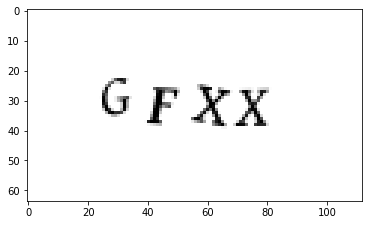

In [30]:
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3) # 2D gray image -> 3D color image

# show the 3D image
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(output)
plt.show()

CAPTCHA text is: FFXX


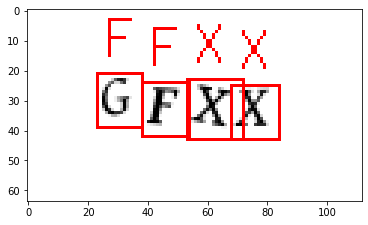

In [31]:
import tensorflow as tf


predictions = []

# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    # Re-size the letter image to 20x20 pixels to match training data
    letter_image = resize_to_fit(letter_image, 20, 20)
    
    # Turn the single image into a 4D list of images to make Keras happy
    # 4D: image_number (=1) x height x width x channel (=1)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    
    letter_image = tf.cast(letter_image, tf.float32)
    
    # Ask the neural network to make a prediction
    prediction = model.predict(letter_image) # output is one-hot encoded
        
    letter = lb.inverse_transform(prediction)[0]
    # use [0] since there is only one test data's label item in the list
    predictions.append(letter)
    
    # draw the prediction on the output image
    # (255, 0, 0) = red
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (255, 0, 0), 1)
    cv2.putText(output, letter, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 1)

# see prediction result:

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)
plt.show()

Questions: Is the prediction correct? How many letters are correctly predicted?
    
**Type Your Answer Here:**

The prediction is 75% correct. 3 out of 4 letters have been correctly predicted.